## The fill algorithm

Our goal here is to cut a deep trench along the edges of the raster to which the flow can "sink".

After that we try to get the flow algorithms to work - be it in QGIS or here.

We are doing this because of failures with default QGIS tools.

In [1]:
import rasterio
import numpy as np
import os

# --- CONFIGURATION ---
input_dem = "/home/pete/Documents/wfrp/source_rasters/wfrp_empire_topo_detail.tif"
output_dem = "/home/pete/Documents/wfrp/source_rasters/wfrp_empire_topo_detail_burned.tif"

# Threshold to consider "Sea" (since floats might be 0.00001)
SEA_THRESHOLD = 0.1 

# The value to burn into the edge to create the "Drain"
DRAIN_VALUE = -10.0 

def burn_edge_drains(input_path, output_path):
    print(f"Opening: {input_path}")
    
    with rasterio.open(input_path) as src:
        # Read the first band
        # masked=True allows numpy to respect existing NoData
        dem_data = src.read(1, masked=True)
        
        # Get metadata to write the file back later
        profile = src.profile.copy()
        
        # --- 1. CREATE EDGE MASK ---
        rows, cols = dem_data.shape
        edge_mask = np.zeros(dem_data.shape, dtype=bool)
        
        # Mark the 1-pixel border around the entire map
        edge_mask[0, :] = True   # Top row
        edge_mask[-1, :] = True  # Bottom row
        edge_mask[:, 0] = True   # Left column
        edge_mask[:, -1] = True  # Right column
        
        # --- 2. IDENTIFY SEA PIXELS ---
        # Find pixels that are valid (not NoData) AND effectively zero
        # We fill NoData with a high value just for the comparison to avoid warnings
        filled_data = dem_data.filled(9999) 
        sea_mask = (filled_data <= SEA_THRESHOLD) & (filled_data > -9000)
        
        # --- 3. COMBINE MASKS ---
        # We want pixels that are ON THE EDGE **AND** ARE SEA
        drain_locations = edge_mask & sea_mask
        
        count = np.count_nonzero(drain_locations)
        print(f"Found {count} pixels at the edge classified as Sea.")
        
        if count == 0:
            print("WARNING: No Sea pixels found touching the map edge!")
            print("Algorithms may still treat the map as a closed container.")
        else:
            print(f"Burning DRAIN_VALUE ({DRAIN_VALUE}) into these {count} pixels...")
            
            # --- 4. APPLY THE BURN ---
            # We modify the array directly. 
            # Note: We must ensure we write into the underlying data, not the mask.
            dem_data[drain_locations] = DRAIN_VALUE
            
            # If the input had a Nodata value, ensure our drain value isn't equal to it
            if src.nodata is not None and DRAIN_VALUE == src.nodata:
                print("Warning: Drain value equals NoData value. This might cause issues.")

        # --- 5. SAVE OUTPUT ---
        print(f"Saving to: {output_path}")
        with rasterio.open(output_path, 'w', **profile) as dst:
            dst.write(dem_data, 1)
            
    print("Done.")

# --- EXECUTE ---
if __name__ == "__main__":
    # Ensure directory exists
    output_dir = os.path.dirname(output_dem)
    if not os.path.exists(output_dir) and output_dir != '':
        os.makedirs(output_dir)
        
    burn_edge_drains(input_dem, output_dem)

Opening: /home/pete/Documents/wfrp/source_rasters/wfrp_empire_topo_detail.tif
Found 2300 pixels at the edge classified as Sea.
Burning DRAIN_VALUE (-10.0) into these 2300 pixels...
Saving to: /home/pete/Documents/wfrp/source_rasters/wfrp_empire_topo_detail_burned.tif
Done.


In [4]:
import whitebox
import os

wbt = whitebox.WhiteboxTools()
wbt.set_working_dir("/home/pete/Documents/wfrp/source_rasters/")
wbt.verbose = True  # Set to True to see progress


# 1. DEFINE FILENAMES
input_dem = "wfrp_empire_topo_detail_burned.tif" # The one with the burned edge!
filled_dem = "wfrp_empire_topo_filled.tif"
diff_raster = "wfrp_empire_topo_depression_mask.tif"  # This is your "Potential Lakes" map

# 2. RUN THE FILL (You likely already ran this)
print("Filling depressions...")
wbt.fill_depressions(input_dem, filled_dem)

# 3. CALCULATE THE DIFFERENCE
# Formula: Filled_DEM - Original_Burned_DEM
print("Calculating depression depth mask...")
wbt.subtract(filled_dem, input_dem, diff_raster)

print("Done. 'Depression_Mask_Depth.tif' contains the depth of every filled sink.")


# # OPTION B: The "Ridge Killer" (Breach Depressions)
# # This creates a least-cost path through obstructions rather than filling them.
# # It is usually geomorphologically more accurate for cutting through 
# # road embankments or digital dams (like map edges).
# wbt.breach_depressions_least_cost(
#     dem = "input_dem.tif", 
#     output = "output_breached.tif", 
#     dist = 100,  # Max search distance in pixels (adjust based on scale)
#     fill = True  # Fill any remaining stubborn sinks after breaching
# )

Filling depressions...
./whitebox_tools --run="FillDepressions" --wd="/home/pete/Documents/wfrp/source_rasters" --dem='wfrp_empire_topo_detail_burned.tif' --output='wfrp_empire_topo_filled.tif' --fix_flats -v --compress_rasters=False

******************************
* Welcome to FillDepressions *
* Powered by WhiteboxTools   *
* www.whiteboxgeo.com        *
******************************
Reading data...
Finding pit cells: 12%
Finding pit cells: 25%
Finding pit cells: 37%
Finding pit cells: 50%
Finding pit cells: 62%
Finding pit cells: 75%
Finding pit cells: 87%
Finding pit cells: 100%
Filling depressions: 0%
Filling depressions: 1%
Filling depressions: 2%
Filling depressions: 3%
Filling depressions: 4%
Filling depressions: 5%
Filling depressions: 6%
Filling depressions: 7%
Filling depressions: 8%
Filling depressions: 9%
Filling depressions: 10%
Filling depressions: 11%
Filling depressions: 12%
Filling depressions: 13%
Filling depressions: 14%
Filling depressions: 15%
Filling depressions

In [5]:
# 4. RUN FLOW ACCUMULATION (D8)
print("Calculating Flow Accumulation...")
flow_acc_raster = "wfrp_empire_topo_flow_acc.tif"

# This generates the D8 Flow Accumulation raster
wbt.d8_flow_accumulation(filled_dem, flow_acc_raster)

Calculating Flow Accumulation...
./whitebox_tools --run="D8FlowAccumulation" --wd="/home/pete/Documents/wfrp/source_rasters" --input='wfrp_empire_topo_filled.tif' --output='wfrp_empire_topo_flow_acc.tif' --out_type=cells -v --compress_rasters=False

*********************************
* Welcome to D8FlowAccumulation *
* Powered by WhiteboxTools      *
* www.whiteboxgeo.com           *
*********************************
Reading data...
Flow directions: 0%
Flow directions: 1%
Flow directions: 2%
Flow directions: 3%
Flow directions: 4%
Flow directions: 5%
Flow directions: 6%
Flow directions: 7%
Flow directions: 8%
Flow directions: 9%
Flow directions: 10%
Flow directions: 11%
Flow directions: 12%
Flow directions: 13%
Flow directions: 14%
Flow directions: 15%
Flow directions: 16%
Flow directions: 17%
Flow directions: 18%
Flow directions: 19%
Flow directions: 20%
Flow directions: 21%
Flow directions: 22%
Flow directions: 23%
Flow directions: 24%
Flow directions: 25%
Flow directions: 26%
Flow di

0

In [8]:
# Optional: Extract streams directly as a raster mask (e.g. threshold > 1000)
wbt.extract_streams(flow_acc_raster, output="wfrp_empire_rivers_20000.tif", threshold=20000.0)

./whitebox_tools --run="ExtractStreams" --wd="/home/pete/Documents/wfrp/source_rasters" --flow_accum='wfrp_empire_topo_flow_acc.tif' --output='wfrp_empire_rivers_20000.tif' --threshold='20000.0' -v --compress_rasters=False

*****************************
* Welcome to ExtractStreams *
* Powered by WhiteboxTools  *
* www.whiteboxgeo.com       *
*****************************
Reading data...
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress: 39%
Progress: 40%
Progress: 41%
Progress: 42%
Progress: 43%
Prog

0

## Vectorizing the river net (new)

The goal here is to take a bunch of QGIS polygons and change them into an actual net of lines for downstream processing.

In [1]:
import geopandas as gpd
from shapely.ops import unary_union
from centerline.geometry import Centerline
from typing import Tuple, Optional
import os

In [ ]:
def load_and_project(filepath: str, processing_epsg: int = 3857) -> Tuple[gpd.GeoDataFrame, any]:
    """
    Loads a spatial file and projects it to a metric CRS for processing.
    
    Returns:
        tuple: (Projected GeoDataFrame, Original CRS object)
    """
    print(f"Reading {filepath}...")
    gdf = gpd.read_file(filepath)
    original_crs = gdf.crs

    if gdf.crs.to_epsg() != processing_epsg:
        print(f"Reprojecting data to EPSG:{processing_epsg} for accurate buffering...")
        gdf = gdf.to_crs(epsg=processing_epsg)
        
    return gdf, original_crs

In [ ]:
def bridge_discontinuous_polygons(gdf: gpd.GeoDataFrame, gap_tolerance: float) -> gpd.GeoDataFrame:
    """
    Performs morphological closing (Buffer -> Union -> Negative Buffer)
    to connect adjacent polygons.
    """
    print(f"Bridging gaps with a tolerance of {gap_tolerance} meters...")
    
    # 1. Dilate (Buffer)
    # Buffering creates rounded corners; cap_style=3 (square) can sometimes help 
    # preserve shape, but default (round) is usually best for rivers.
    buffered = gdf.geometry.buffer(gap_tolerance)
    
    # 2. Union (Merge)
    # Compresses all shapes into a single MultiPolygon
    merged_geom = unary_union(buffered)
    
    # 3. Erode (Negative Buffer)
    # Returns the shape to approx original size, but bridges remain
    eroded_geom = merged_geom.buffer(-gap_tolerance)
    
    # 4. Re-structure
    # Create a new GDF and explode MultiPolygons into individual Polygons
    # (e.g., if you have two distinct river systems in the file)
    new_gdf = gpd.GeoDataFrame(geometry=[eroded_geom], crs=gdf.crs)
    new_gdf = new_gdf.explode(index_parts=False).reset_index(drop=True)
    
    print(f"Merged into {len(new_gdf)} continuous river system(s).")
    return new_gdf

In [ ]:
def extract_centerlines(gdf: gpd.GeoDataFrame, interp_dist: float = 10.0) -> gpd.GeoDataFrame:
    """
    Iterates through polygon geometries and calculates Voronoi centerlines.
    
    Args:
        interp_dist: Density of vertices on the border. Lower = higher precision but slower.
    """
    print("Calculating Voronoi centerlines (this may take time)...")
    lines = []
    
    # Filter out empty or None geometries to prevent errors
    valid_gdf = gdf[~gdf.geometry.is_empty & ~gdf.geometry.isna()]

    for idx, row in valid_gdf.iterrows():
        try:
            # Centerline expects a single Polygon
            cl = Centerline(row.geometry, interpolation_distance=interp_dist)
            lines.append(cl.geometry)
        except Exception as e:
            print(f"Warning: Failed to skeletonize polygon at index {idx}: {e}")
            # Optional: Append the original geometry or skip
            continue
            
    return gpd.GeoDataFrame(geometry=lines, crs=gdf.crs)

In [ ]:
def save_results(gdf: gpd.GeoDataFrame, output_path: str, target_crs: any):
    """
    Reprojects data back to original CRS and saves to GPKG.
    """
    print("Reprojecting and saving output...")
    
    # Reproject if necessary
    if target_crs and gdf.crs != target_crs:
        gdf = gdf.to_crs(target_crs)
        
    gdf.to_file(output_path, driver="GPKG")
    print(f"Successfully saved to: {output_path}")

In [ ]:
def run_river_pipeline(input_file: str, output_file: str, gap_size: float = 50.0):
    """
    Main execution pipeline.
    """
    # 1. Load
    gdf, orig_crs = load_and_project(input_file)
    
    # 2. Process: Connect
    connected_gdf = bridge_discontinuous_polygons(gdf, gap_tolerance=gap_size)
    
    # 3. Process: Skeletonize
    centerlines_gdf = extract_centerlines(connected_gdf, interp_dist=10)
    
    # 4. Save
    save_results(centerlines_gdf, output_file, orig_crs)

In [ ]:
if __name__ == "__main__":
    # Example configuration
    IN_FILE = "data/raw_rivers.gpkg"
    OUT_FILE = "data/river_lines.gpkg"
    
    # Run only if file exists to prevent copy-paste errors
    if os.path.exists(IN_FILE):
        run_river_pipeline(IN_FILE, OUT_FILE, gap_size=30)
    else:
        print(f"File not found: {IN_FILE}")

## Vectorize the river net (legacy)

Old approach to vectorizing the river net, as extracted from the flow raster.

In [5]:
import rasterio
from rasterio import features
import geopandas as gpd
from shapely.geometry import shape
from skimage.morphology import skeletonize
import matplotlib.pyplot as plt
import numpy as np
import rasterstats
import pandas as pd
from shapely.ops import linemerge
from shapely.geometry import box
from centerline.geometry import Centerline
import fiona

In [2]:
# --- 1. Define Input and Output Files ---
FLOW_RASTER_PATH = "/home/pete/Documents/wfrp/physical_rasters/13_topo_rivers.tif"
VECTOR_POLY_PATH = "/home/pete/Documents/wfrp/physical_vectors/931_rivers_flow_values_cleaned.gpkg"
VECTOR_LINE_PATH = "/home/pete/Documents/wfrp/physical_vectors/933_rivers_line_segments.gpkg"
VECTOR_LINES_BINNED = "/home/pete/Documents/wfrp/physical_vectors/932_rivers_binned.gpkg"
THRESHOLD = 2500

In [15]:
# --- 2. Load Raster, Apply Threshold, and Skeletonize ---
print(f"Loading {FLOW_RASTER_PATH}...")
with rasterio.open(FLOW_RASTER_PATH) as src:
    image = src.read(1)
    transform = src.transform
    crs = src.crs
    print(f"Applying threshold (> {THRESHOLD})...")
    binary_image = image > THRESHOLD
    print("Skeletonizing the binary image...")
    skeleton = skeletonize(binary_image)
    skeleton = skeleton.astype(np.uint8)

# --- 3. Vectorize the Skeleton ---
print("Vectorizing the skeleton...")
shapes = features.shapes(
    skeleton, 
    mask=(skeleton > 0),
    transform=transform
)
geometries = [shape(geom) for geom, val in shapes]

# --- 4. Create GeoDataFrame ---
if geometries:
    print("Creating GeoDataFrame...")
    gdf = gpd.GeoDataFrame(geometry=geometries, crs=crs)

    # --- 5. NEW: Sample Flow Values from Original Raster ---
    print("Sampling original flow accumulation values for each line...")
    # Calculate the mean flow value for the pixels each line crosses
    stats = rasterstats.zonal_stats(
        gdf,          # Your new vector lines
        image,        # The original flow accumulation data (as a NumPy array)
        affine=transform,
        stats=['max'] # You can also use 'max', 'min', etc.
    )
    
    # Extract the mean values and add them to a new column
    mean_flow_values = [s['max'] for s in stats]
    gdf['flow_acc'] = mean_flow_values
    
    # --- 6. Save the Final File ---
    print("Saving file with flow accumulation attributes...")
    gdf.to_file(VECTOR_POLY_PATH, driver='GPKG')
    print(f"Success! File saved to {VECTOR_POLY_PATH}")
else:
    print("No features found for the given threshold. Please try a lower value.")

Loading /home/pete/Documents/wfrp/physical_rasters/13_topo_rivers.tif...
Applying threshold (> 2500)...
Skeletonizing the binary image...
Vectorizing the skeleton...
Creating GeoDataFrame...
Sampling original flow accumulation values for each line...
Saving file with flow accumulation attributes...


/home/pete/miniconda/envs/gdgtm_dev/lib/python3.12/site-packages/pyogrio/geopandas.py:662: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(


Success! File saved to /home/pete/Documents/wfrp/physical_vectors/931_rivers_flow_values_cleaned.gpkg


In [6]:
layer_names = fiona.listlayers(VECTOR_POLY_PATH)
print(f"Layers found in file: {layer_names}")

Layers found in file: ['931_rivers_flow_values', '931_rivers_flow_values_cleaned']


Reading file: /home/pete/Documents/wfrp/physical_vectors/931_rivers_flow_values_cleaned.gpkg
Generating histogram...


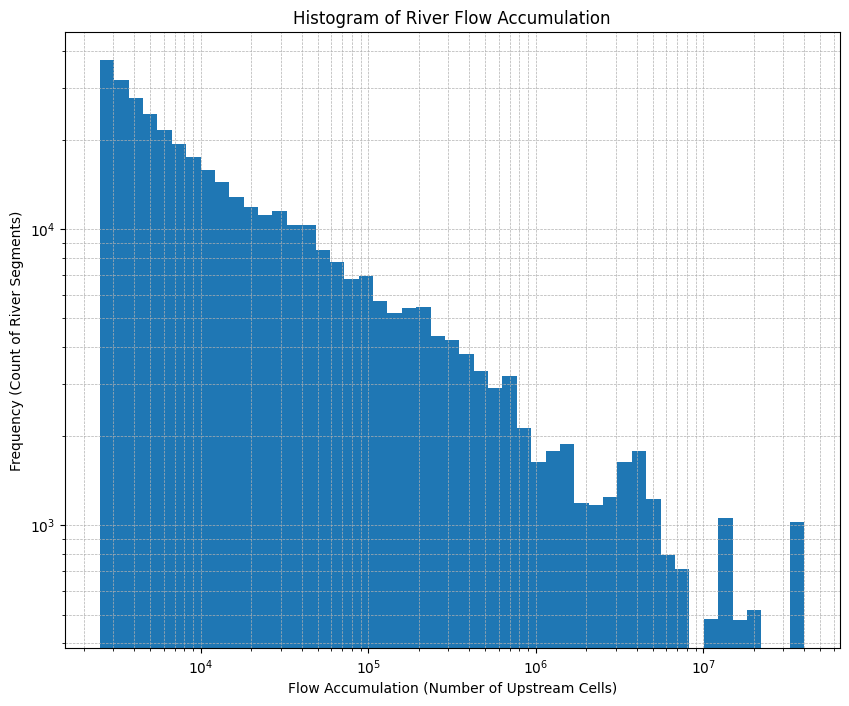

Done.


In [4]:
print(f"Reading file: {VECTOR_POLY_PATH}")
LAYER_TO_USE = '931_rivers_flow_values_cleaned'
gdf = gpd.read_file(VECTOR_POLY_PATH, layer=LAYER_TO_USE)

# Ensure there are positive flow values to plot on a log scale
flow_values = gdf['flow_acc'][gdf['flow_acc'] > 0]

if flow_values.empty:
    print("No positive flow accumulation values found to plot.")
else:
    print("Generating histogram...")
    # --- 2. Create the Plot ---
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))

    # Create a histogram of the flow accumulation values
    ax.hist(flow_values, bins=np.logspace(np.log10(flow_values.min()), np.log10(flow_values.max()), 50))

    # --- 3. Set Logarithmic Scales and Labels ---
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_title('Histogram of River Flow Accumulation')
    ax.set_xlabel('Flow Accumulation (Number of Upstream Cells)')
    ax.set_ylabel('Frequency (Count of River Segments)')
    ax.grid(True, which="both", ls="--", linewidth=0.5)

    # --- 4. Show the Plot ---
    plt.show()
    print("Done.")

In [ ]:
import geopandas as gpd
from centerline.geometry import Centerline

print(f"Loading polygons from {VECTOR_POLY_PATH}...")
LAYER_TO_USE = '931_rivers_flow_values_cleaned'
gdf = gpd.read_file(VECTOR_POLY_PATH, layer=LAYER_TO_USE)

new_geometries = []
flow_values = []

print("Iterating and converting polygons to centerlines...")
# Iterate over each row (each tiny polygon)
for index, row in gdf.iterrows():
    try:
        # Calculate the centerline for this one polygon
        # Use an interpolation_distance based on your pixel size (e.g., 10)
        centerline_geom = Centerline(row.geometry, interpolation_distance=10).geometry
        
        # Add the new line and its original flow value to our lists
        new_geometries.append(centerline_geom)
        flow_values.append(row['flow_acc'])
    except Exception as e:
        # This catches any tiny polygons that are too small or weird to process
        print(f"Skipping a polygon (likely too small): {e}")

print("Creating new line GeoDataFrame...")
# Create a new GeoDataFrame from the centerline geometries
line_gdf = gpd.GeoDataFrame(
    {'flow_acc': flow_values},
    geometry=new_geometries,
    crs=gdf.crs
)

In [8]:
print(f"Saving final line file to: {VECTOR_LINE_PATH}")
line_gdf.to_file(VECTOR_LINE_PATH, driver='GPKG')

print("Done. You now have a true vector line file with flow values.")

Saving final line file to: /home/pete/Documents/wfrp/physical_vectors/933_rivers_line_segments.gpkg


/home/pete/miniconda/envs/gdgtm_dev/lib/python3.12/site-packages/pyogrio/geopandas.py:662: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(


Done. You now have a true vector line file with flow values.


In [3]:
print(f"Reading file: {VECTOR_LINE_PATH}")
gdf = gpd.read_file(VECTOR_LINE_PATH)

# --- 2. Categorize the Rivers ---
print("Categorizing rivers into manually defined size classes...")

# 1. DEFINE YOUR MANUAL BINS (Thresholds)
# The first value should be the minimum, the last should be infinity.
# Example: 0-1000 is Cat 1, 1001-5000 is Cat 2, etc.
bins = [
    -1,          # Start at -1 to include 0 in the first category
    10**5,        # Category 1: ( -1 to 1000]
    10**6,        # Category 2: (1000 to 5000]
    10**7,       # Category 3: (5000 to 20000]
    10**7.2,      # Category 4: (20000 to 100000]
    np.inf       # Category 5: (100000 to infinity]
]

# 2. DEFINE YOUR LABELS (Category numbers)
# Must be one less than the number of bins.
labels = [1, 2, 3, 4, 5]

# 3. CREATE THE NEW 'category' COLUMN
# pd.cut handles the logic of which bin each 'flow_acc' value falls into
gdf['category'] = pd.cut(
    gdf['flow_acc'], 
    bins=bins, 
    labels=labels, 
    include_lowest=True
).cat.add_categories(0).fillna(0)

Reading file: /home/pete/Documents/wfrp/physical_vectors/933_rivers_line_segments.gpkg
Categorizing rivers into manually defined size classes...


In [ ]:
# --- 4. CREATE GRID ---
GRID_SIZE = 50000
print("Creating processing grid...")
xmin, ymin, xmax, ymax = gdf.total_bounds
cols = list(np.arange(xmin, xmax + GRID_SIZE, GRID_SIZE))
rows = list(np.arange(ymin, ymax + GRID_SIZE, GRID_SIZE))

grid_cells = [box(x0, y0, x1, y1) for x0, x1 in zip(cols[:-1], cols[1:]) for y0, y1 in zip(rows[:-1], rows[1:])]
grid_gdf = gpd.GeoDataFrame(geometry=grid_cells, crs=gdf.crs)
grid_gdf['grid_id'] = grid_gdf.index # Add a simple ID for grouping

# --- 5. MAP PHASE: Split lines by grid ---
print("Map phase: Splitting lines against grid (this is the first big step)...")
# This is the new, crucial step: gpd.overlay()
# It replaces the loop, sindex.query, and clip.
# It correctly splits lines at grid boundaries.
split_lines_gdf = gpd.overlay(gdf, grid_gdf, how='intersection', keep_geom_type=True)

# --- 6. REDUCE-STEP-1: Merge within chunks ---
print("Reduce step 1: Merging lines within each grid cell...")
# Group by both grid_id AND category.
# Add observed=True to silence the warning.
grouped_in_cells = split_lines_gdf.groupby(['grid_id', 'category'], observed=True)

# Apply the merge logic.
# Use .union_all() to silence the deprecation warning.
merged_in_cells = grouped_in_cells['geometry'].apply(lambda x: linemerge(x.union_all()))

# --- 7. REDUCE-STEP-2: Final Merge ---
print("Reduce step 2: Merging lines from all cells...")

# We now have a pandas Series where the index is ('grid_id', 'category')
# Reset the index to make 'category' a column again
merged_in_cells_gdf = merged_in_cells.reset_index()

# Group again, this time *only* by category.
final_grouped = merged_in_cells_gdf.groupby('category', observed=True)

# Run the final linemerge
final_merged_geoms = final_grouped['geometry'].apply(lambda x: linemerge(x.union_all()))

# --- 8. Create and Save Final GeoDataFrame ---
print("Creating and saving final file...")
# Create the final GDF
# We pass the CRS *directly* to the constructor to fix the 3rd warning.
final_gdf = gpd.GeoDataFrame(geometry=final_merged_geoms, crs=gdf.crs).reset_index()

In [11]:
# Save
final_gdf.to_file(VECTOR_LINES_BINNED, driver='GPKG')

print("Done.")

/home/pete/miniconda/envs/gdgtm_dev/lib/python3.12/site-packages/pyogrio/geopandas.py:662: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(


Done.


## Make the small lakes

In [11]:
import whitebox
import rasterio
import numpy as np

In [15]:
DEM_IN_PATH = "/home/pete/Documents/wfrp/environment_layers/l001_dem.tif"
DEM_FAKE_CRS_PATH = "/home/pete/Documents/wfrp/physical_rasters/14_lakes_dem_fake_crs.tif" # New temporary file
DEM_FILLED_PATH = "/home/pete/Documents/wfrp/physical_rasters/14_lakes_fake_crs.tif"
SINK_DEPTHS_PATH = "/home/pete/Documents/wfrp/physical_rasters/14_lakes_small.tif"

In [13]:
print(f"Loading {DEM_IN_PATH}...")
with rasterio.open(DEM_IN_PATH) as src:
    dem_array = src.read(1)
    profile = src.profile # Get metadata

# --- THIS IS THE FIX ---
print("Replacing problematic CRS with a standard one (EPSG:32632)...")
# We use a standard UTM projection as a "spoof"
profile['crs'] = "EPSG:32632" 
# We keep the transform, as whitebox-tools will just use it for pixel size
# ------------------------

print(f"Saving 'fake CRS' DEM to {DEM_FAKE_CRS_PATH}...")
with rasterio.open(DEM_FAKE_CRS_PATH, 'w', **profile) as dst:
    dst.write(dem_array, 1)

print("'Fake CRS' copy created.")

Loading /home/pete/Documents/wfrp/environment_layers/l001_dem.tif...
Replacing problematic CRS with a standard one (EPSG:32632)...
Saving 'fake CRS' DEM to /home/pete/Documents/wfrp/physical_rasters/14_lakes_dem_fake_crs.tif...
'Fake CRS' copy created.


In [14]:
# Initialize WhiteboxTools
wbt = whitebox.WhiteboxTools()
wbt.verbose = True # Keep this on to see errors

# --- RUN SINK FILLING ---
print("Running whitebox.fill_depressions() on CRS-less file...")
wbt.fill_depressions(
    dem=DEM_FAKE_CRS_PATH,
    output=DEM_FILLED_PATH
)

Running whitebox.fill_depressions() on CRS-less file...
./whitebox_tools --run="FillDepressions" --dem='/home/pete/Documents/wfrp/physical_rasters/14_lakes_dem_fake_crs.tif' --output='/home/pete/Documents/wfrp/physical_rasters/14_lakes_fake_crs.tif' --fix_flats -v --compress_rasters=False

******************************
* Welcome to FillDepressions *
* Powered by WhiteboxTools   *
* www.whiteboxgeo.com        *
******************************
Reading data...
Finding pit cells: 12%
Finding pit cells: 25%
Finding pit cells: 37%
Finding pit cells: 50%
Finding pit cells: 62%
Finding pit cells: 75%
Finding pit cells: 87%
Finding pit cells: 100%
Filling depressions: 0%
Filling depressions: 1%
Filling depressions: 2%
Filling depressions: 3%
Filling depressions: 4%
Filling depressions: 5%
Filling depressions: 6%
Filling depressions: 7%
Filling depressions: 8%
Filling depressions: 9%
Filling depressions: 10%
Filling depressions: 11%
Filling depressions: 12%
Filling depressions: 13%
Filling depre

0

In [17]:
print("Calculating sink depths...")

# Read the original file to get its metadata (profile)
with rasterio.open(DEM_IN_PATH) as original_src:
    original_dem = original_src.read(1).astype(np.float32)
    original_profile = original_src.profile # Has the correct, original CRS

# Read the new filled file
with rasterio.open(DEM_FILLED_PATH) as filled_src:
    filled_dem = filled_src.read(1).astype(np.float32)

# Check if shapes match (they should)
if original_dem.shape != filled_dem.shape:
    print("Error: Shape mismatch. Aborting.")
else:
    # Calculate depths
    sink_depths = filled_dem - original_dem
    nodata = original_profile.get('nodata')
    
    # Handle nodata
    if nodata is not None:
        sink_depths[original_dem == nodata] = nodata

    # Update profile to float32
    original_profile.update(dtype='float32')

    # --- SAVE WITH ORIGINAL CRS ---
    print(f"Saving sink depths (with original CRS) to {SINK_DEPTHS_PATH}...")
    with rasterio.open(SINK_DEPTHS_PATH, 'w', **original_profile) as dst:
        dst.write(sink_depths, 1)

    print("Processing complete.")

Calculating sink depths...
Saving sink depths (with original CRS) to /home/pete/Documents/wfrp/physical_rasters/14_lakes_small.tif...
Processing complete.


In [20]:
import rasterio
import numpy as np
from skimage import measure

SINK_DEPTHS_IN_PATH = "/home/pete/Documents/wfrp/physical_rasters/14_lakes_small.tif"
SMALL_LAKES_OUT_PATH = "/home/pete/Documents/wfrp/physical_rasters/14_lakes_small_CLEANED.tif"

In [29]:
# Define the maximum size (in pixels) for a lake to be KEPT.
# Any contiguous basin larger than this will be erased.
# This is your 'N' value. Try a few values, e.g., 10000.
MAX_LAKE_SIZE_PIXELS = 10000 
# ----------------------------------------

print(f"Loading {SINK_DEPTHS_IN_PATH}...")
with rasterio.open(SINK_DEPTHS_IN_PATH) as src:
    sink_depths = src.read(1).astype(np.float32)
    profile = src.profile # Get metadata
    nodata = profile.get('nodata')

    # Make a copy for our output
    final_output_array = sink_depths.copy()

Loading /home/pete/Documents/wfrp/physical_rasters/14_lakes_small.tif...


In [30]:
# --- 2. Create a Binary Mask ---
# We need a simple 1s (basin) and 0s (not basin) array
if nodata is not None:
    binary_basins = (sink_depths > 0) & (sink_depths != nodata)
else:
    binary_basins = (sink_depths > 0)

# --- 3. Find and Label All Blobs ---
print("Finding all connected basins...")
# This function finds all contiguous "blobs" and gives each a unique integer ID
# connectivity=2 means it checks 8-way (including diagonals)
labeled_array = measure.label(binary_basins, connectivity=2)

Finding all connected basins...


In [31]:
# --- 4. Count Sizes and Find "Bad" (Large) Labels ---
print("Calculating size of each basin...")
# np.bincount is a very fast way to count pixels for each label
# The index is the label ID, the value is the pixel count
label_sizes = np.bincount(labeled_array.ravel())

# Find the label IDs of all blobs that are TOO BIG
all_label_ids = np.arange(len(label_sizes))
# Note: we skip label 0, which is the background
bad_label_ids = all_label_ids[label_sizes > MAX_LAKE_SIZE_PIXELS]

print(f"Found {len(bad_label_ids)} basins that are too large and will be removed.")

Calculating size of each basin...
Found 197 basins that are too large and will be removed.


In [32]:
# --- 5. Create a "Kill Mask" and Apply It ---
# np.isin() is a fast way to find all pixels that belong to a "bad" label
kill_mask = np.isin(labeled_array, bad_label_ids)

# Set all pixels in the original array that are part of a "bad" blob to 0
final_output_array[kill_mask] = 0

print("Large basins have been erased.")

# --- 6. Save the Cleaned Raster ---
print(f"Saving cleaned raster to {SMALL_LAKES_OUT_PATH}...")
with rasterio.open(SMALL_LAKES_OUT_PATH, 'w', **profile) as dst:
    dst.write(final_output_array, 1)

print("Done.")

Large basins have been erased.
Saving cleaned raster to /home/pete/Documents/wfrp/physical_rasters/14_lakes_small_CLEANED.tif...
Done.
